## Cài đặt các thư viện cần thiết

In [1]:
!pip install torchtext==0.6.0
!pip install spacy
!pip install https://gitlab.com/trungtv/vi_spacy/-/raw/master/vi_core_news_lg/dist/vi_core_news_lg-0.0.1.tar.gz
!pip install Pyvi
!pip install en_core_web_sm
!pip install langdetect
!pip install contractions
!pip install dill

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 23.7 MB/s eta 0:00:00
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.15.2
    Uninstalling torchtext-0.15.2:
      Successfully uninstalled torchtext-0.15.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.5/254.5 MB 5.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 48.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 659.5/659.5 kB 55.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.8/82.8 kB 9.5 MB/s eta 0:00:00
  Created wheel for vi-core-news-lg: filename=vi_core_news_lg-0.0.1-py3-none-any.whl size=254513599 sha256=3accc2124fe39ae912089730eac063ecfc903ee915a3ecbe702ee6c583feceb5
  Stored in directory: /root/.cache/pip/wheels/9f/44/ad/99e

In [2]:
from torchtext.data import Field, Example, Dataset, BucketIterator
import os
import langdetect
import re
import torch
import torch.optim as  optim
from torch import nn
import numpy as np
from torchtext import data
import spacy
from spacy.lang.vi import Vietnamese
import contractions
import pandas as pd
import dill

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Chuẩn bị dữ liệu

Mô hình token hóa dữ liệu tiếng Anh và tiếng Việt

In [4]:
nlp_vi = Vietnamese()
nlp_en = spacy.load("en_core_web_sm")

def tokenize_vi(text):
    return [token.text for token in nlp_vi.tokenizer(text)]

def tokenize_en(text):
    return [token.text for token in nlp_en.tokenizer(text)]

In [5]:
source = Field(tokenize=tokenize_vi, init_token='<sos>', eos_token='<eos>', lower=True)
target = Field(tokenize=tokenize_en, init_token='<sos>', eos_token='<eos>', lower=True)

fields = {"Vietnamese": ("src", source), "English": ("trg", target)}

Đọc và xử lý dữ liệu:
- Loại bỏ các ký tự không phải từ, xóa dấu cách dư thừa.
- Đối với tiếng Anh: Chuyển đổi các từ viết gọn (Vd: I'm -> I am, you're -> you are)

In [6]:
!wget "https://github.com/ppl160902/statistical_learning/raw/main/dataset/english_vietnamese.csv"
df = pd.read_csv("/content/english_vietnamese.csv")

--2023-06-29 15:26:37--  https://github.com/ppl160902/statistical_learning/raw/main/dataset/english_vietnamese.csv
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/ppl160902/statistical_learning/main/dataset/english_vietnamese.csv [following]
--2023-06-29 15:26:37--  https://raw.githubusercontent.com/ppl160902/statistical_learning/main/dataset/english_vietnamese.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 21186474 (20M) [text/plain]
Saving to: ‘english_vietnamese.csv’

english_vietnamese. 100%[===================>]  20.20M  --.-KB/s    in 0.1s    

2023-06-29 15:26:38 (150 MB/s) - ‘englis

In [7]:
def transform_text(text, eng=True):
    if eng:
        text = contractions.fix(text)
    s = re.sub(r'[^\w\s]', '', text)
    s = re.sub('\s+',' ',s).strip()
    return s.lower()

In [8]:
df['english'] = df['english'].apply(transform_text)
df['vietnamese'] = df['vietnamese'].apply(transform_text, eng=False)

In [9]:
sources = df['vietnamese'].to_list()
targets = df['english'].to_list()
examples = []
for src_sentence, trg_sentence in zip(sources, targets):
    example = Example.fromlist([src_sentence, trg_sentence], fields=[('src', source), ('trg', target)])
    examples.append(example)

Tạo dateset, gồm train data, valid data và test data

In [10]:
# Tạo dataset từ example
dataset = Dataset(examples, fields=[('src', source), ('trg', target)])

# Chia train, valid, test
train_data, valid_data, test_data = dataset.split(split_ratio=[0.7, 0.15, 0.15])

# Xây dựng vocabulary
source.build_vocab(train_data,min_freq=2)
target.build_vocab(train_data,min_freq=2)

print(target.vocab.freqs.most_common(10))


[('i', 54511), ('the', 45249), ('to', 45199), ('tom', 37461), ('you', 37283), ('is', 30458), ('not', 29919), ('a', 28317), ('do', 17117), ('he', 16689)]


In [11]:
with open("/content/source_V2E.Field","wb")as f:
     dill.dump(source,f)

with open("/content/target_V2E.Field","wb")as f:
     dill.dump(target,f)

## Thiết lập và chọn tham số mô hình

In [21]:
BATCH_SIZE = 64

train_iterator,valid_iterator,test_iterator = data.BucketIterator.splits(
    (train_data,valid_data,test_data),
    batch_size = BATCH_SIZE,
    device = device,
    sort=False,
    sort_within_batch=False,
shuffle=True)

In [22]:
class TranslateTransformer(nn.Module):
    def __init__(
        self,
        embedding_size,
        src_vocab_size,
        trg_vocab_size,
        src_pad_idx,
        num_heads,
        num_encoder_layers,
        num_decoder_layers,
        max_len,
    ):
        super(TranslateTransformer, self).__init__()
        self.srcEmbeddings = nn.Embedding(src_vocab_size,embedding_size)
        self.trgEmbeddings= nn.Embedding(trg_vocab_size,embedding_size)
        self.srcPositionalEmbeddings= nn.Embedding(max_len,embedding_size)
        self.trgPositionalEmbeddings= nn.Embedding(max_len,embedding_size)
        self.transformer = nn.Transformer(
            embedding_size,
            num_heads,
            num_encoder_layers,
            num_decoder_layers,
        )
        self.fc_out = nn.Linear(embedding_size, trg_vocab_size)
        self.dropout = nn.Dropout(0.1)
        self.src_pad_idx = src_pad_idx
        self.max_len = max_len

    def make_src_mask(self, src):
        src_mask = src.transpose(0,1) == self.src_pad_idx

        return src_mask.to(device)

    def forward(self,x,trg):
        src_seq_length = x.shape[0]
        N = x.shape[1]
        trg_seq_length = trg.shape[0]

        src_positions = (
            torch.arange(0, src_seq_length)
            .reshape(src_seq_length,1)  + torch.zeros(src_seq_length,N)
        ).to(device)

        trg_positions = (
            torch.arange(0, trg_seq_length)
            .reshape(trg_seq_length,1)  + torch.zeros(trg_seq_length,N)
        ).to(device)


        srcWords = self.dropout(self.srcEmbeddings(x.long()) +self.srcPositionalEmbeddings(src_positions.long()))
        trgWords = self.dropout(self.trgEmbeddings(trg.long())+self.trgPositionalEmbeddings(trg_positions.long()))

        src_padding_mask = self.make_src_mask(x)
        trg_mask = self.transformer.generate_square_subsequent_mask(trg_seq_length).to(device)


        out = self.transformer(srcWords,trgWords, src_key_padding_mask=src_padding_mask,tgt_mask=trg_mask )
        out= self.fc_out(out)
        return out

In [23]:
src_vocab_size  = len(source.vocab)
print("Size of Vietnamese vocabulary:",src_vocab_size)

trg_vocab_size =len(target.vocab)
print("Size of English vocabulary:",trg_vocab_size)

num_heads = 8
num_encoder_layers = 3
num_decoder_layers = 3

max_len= 225
embedding_size= 256
src_pad_idx = source.vocab.stoi["<pad>"]

model = TranslateTransformer(
    embedding_size,
    src_vocab_size,
    trg_vocab_size,
    src_pad_idx,
    num_heads,
    num_encoder_layers,
    num_decoder_layers,
    max_len
).to(device)

Size of Vietnamese vocabulary: 7878
Size of English vocabulary: 11721


## Huấn luyện mô hình

In [24]:
loss_track = []
loss_validation_track= []

In [25]:
optimizer = optim.Adagrad(model.parameters(), lr = 0.003)
EPOCHS = 60

pad_idx = source.vocab.stoi["<pad>"]
criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)

for i in range(0,EPOCHS):
    stepLoss=[]
    model.train()
    for batch in train_iterator:
        input_sentence = batch.src.to(device)
        trg = batch.trg.to(device)

        optimizer.zero_grad()
        out = model(input_sentence,trg[:-1])
        out = out.reshape(-1,trg_vocab_size)
        trg = trg[1:].reshape(-1)
        loss = criterion(out,trg)

        loss.backward()
        optimizer.step()
        stepLoss.append(loss.item())


    loss_track.append(np.mean(stepLoss))
    print("train crossentropy at epoch {} loss: ".format(i),np.mean(stepLoss))

    stepValidLoss=[]
    total_correct = 0
    total_examples = 0

    model.eval()
    torch.save(model.state_dict(), 'model{:02d}.pth'.format(i+1))
    for batch  in valid_iterator:
        input_sentence = batch.src.to(device)
        trg = batch.trg.to(device)

        optimizer.zero_grad()
        out = model(input_sentence,trg[:-1])
        predictions = out.argmax(dim=-1)
        total_correct += (predictions == trg[1:]).sum().item()
        total_examples += trg[1:].numel()

        out = out.reshape(-1,trg_vocab_size)
        trg = trg[1:].reshape(-1)
        loss = criterion(out,trg)

        stepValidLoss.append(loss.item())

    loss_validation_track.append(np.mean(stepValidLoss))
    accuracy = total_correct / total_examples
    print("validation crossentropy at epoch {} loss: ".format(i),np.mean(stepValidLoss))
    print(f"Accuracy: {accuracy}")

train crossentropy at epoch 0 loss:  3.5509461647314993
validation crossentropy at epoch 0 loss:  2.6112732007199484
Accuracy: 0.2701459813327222
train crossentropy at epoch 1 loss:  2.45456999128671
validation crossentropy at epoch 1 loss:  2.0464280997746744
Accuracy: 0.3043949756806131
train crossentropy at epoch 2 loss:  2.0751578341713914
validation crossentropy at epoch 2 loss:  1.7808274150694776
Accuracy: 0.32182348280292017
train crossentropy at epoch 3 loss:  1.8538631701212136
validation crossentropy at epoch 3 loss:  1.6286056319739195
Accuracy: 0.3321198241311886
train crossentropy at epoch 4 loss:  1.7022594409773675
validation crossentropy at epoch 4 loss:  1.5083056906325705
Accuracy: 0.34033200863370666
train crossentropy at epoch 5 loss:  1.5889746635080242
validation crossentropy at epoch 5 loss:  1.4380361943836981
Accuracy: 0.34310788197947684
train crossentropy at epoch 6 loss:  1.5028387128877982
validation crossentropy at epoch 6 loss:  1.361354123225948
Accurac

## Đánh giá mô hình

In [26]:
def translate(model,sentence,srcField,targetField,srcTokenizer):
    model.eval()
    processed_sentence = srcField.process([srcTokenizer(sentence)]).to(device)
    trg = ["<sos>"]
    for iter in range(60):

        trg_indecies = [targetField.vocab.stoi[word] for word in trg]
        outputs = torch.Tensor(trg_indecies).unsqueeze(1).to(device)
        outputs = model(processed_sentence,outputs)

        if targetField.vocab.itos[outputs.argmax(2)[-1:].item()] == "<unk>":
            continue

        if targetField.vocab.itos[outputs.argmax(2)[-1:].item()] == "<eos>":
            break

        trg.append(targetField.vocab.itos[outputs.argmax(2)[-1:].item()])

    return " ".join([word for word in trg if word != "<unk>"][1:-1])

Kiểm tra độ chính xác của các mô hình

In [27]:
model_test = TranslateTransformer(
    embedding_size,
    src_vocab_size,
    trg_vocab_size,
    src_pad_idx,
    num_heads,
    num_encoder_layers,
    num_decoder_layers,
    max_len
).to(device)

model_accuracy = []

for i in range(EPOCHS):
  model_path = '/content/model{:02d}.pth'.format(i+1)
  model_test.load_state_dict(torch.load(model_path))

  model_test.eval()
  total_correct = 0
  total_examples = 0

  for batch in test_iterator:
      input_sentence = batch.src.to(device)
      trg = batch.trg.to(device)

      with torch.no_grad():
          output = model_test(input_sentence, trg[:-1])
          predictions = output.argmax(dim=-1)

      total_correct += (predictions == trg[1:]).sum().item()
      total_examples += trg[1:].numel()

  accuracy = total_correct / total_examples
  model_accuracy.append(accuracy)
  print(f"Model {i+1}")
  print(f"Accuracy: {accuracy}")
  print("Translated: ",
        translate(model_test,transform_text('Tôi cảm thấy rất mệt mỏi vì đã làm việc suốt cả ngày.', eng=False), source, target, tokenize_en))
  print('=================================================================================')


Model 1
Accuracy: 0.27167535242951407
Translated:  i saw a lot of the same time it was all
Model 2
Accuracy: 0.30778777246939387
Translated:  i saw a very tired because because it was done all
Model 3
Accuracy: 0.32508076385770596
Translated:  i caught very tired on the same time because it was all
Model 4
Accuracy: 0.33409286034242486
Translated:  i feel very tired on the concert because it was done all
Model 5
Accuracy: 0.342286299765808
Translated:  i feel very tired on the concert because it was done all
Model 6
Accuracy: 0.3473198237555544
Translated:  i feel very tired on the whole time did all
Model 7
Accuracy: 0.3514703136669156
Translated:  i feel very tired on the whole time did all
Model 8
Accuracy: 0.3554212173349292
Translated:  i feel very tired on the whole thing that has done all
Model 9
Accuracy: 0.35673079315320694
Translated:  i feel very tired tired because it did all day all
Model 10
Accuracy: 0.3607755079175381
Translated:  i feel very tired tired because it did a

Trực quan độ chính xác của các mô hình

<Axes: >

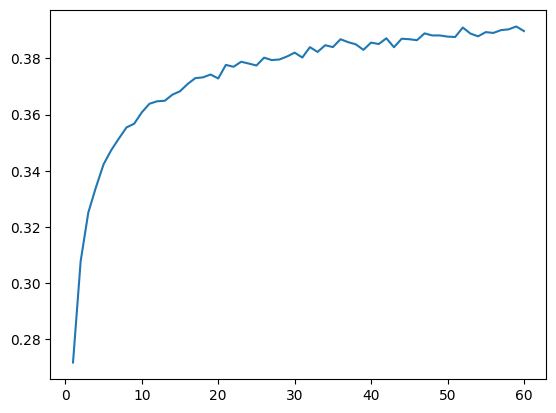

In [28]:
import seaborn as sns
sns.lineplot(x=list(range(1, EPOCHS + 1)), y=model_accuracy)

In [29]:
print('The best model is model{:02d}.pth\nAccuracy = {:.4f}'.format(model_accuracy.index(max(model_accuracy)) + 1, max(model_accuracy)))

The best model is model59.pth
Accuracy = 0.3914
